In [ ]:
# training on P100: 849MB memory, training loss decrease slow
# training on V100: 1255MB memory, training loss decrease much faster

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import math
from google.colab import drive
drive.mount('/content/drive')
device='cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.get_device_name(0))

Mounted at /content/drive
Tesla T4


In [ ]:
!nvidia-smi

Sat Feb 19 17:09:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
filename='/content/drive/MyDrive/gnn/data/data_118_quad/118dc_quad_ISF.txt'
S_isf=pd.read_table(filename,sep=',',header=None).to_numpy() # ISF matrix
filename='/content/drive/MyDrive/gnn/data/data_118_quad/118ac_fmax.txt'
f_max=pd.read_table(filename,sep=',',header=None).to_numpy() # flow limit
n_line = np.size(S_isf,0)
S = torch.from_numpy(S_isf).to(device) # ISF
f_max = torch.from_numpy(f_max).to(device) # flow limit

In [ ]:
f_max.shape

torch.Size([186, 1])

In [ ]:
# x=np.load('/content/drive/MyDrive/gnn/data/dc118_p10_x.npy')
# y=np.load('/content/drive/MyDrive/gnn/data/dc118_p10_y.npy')
# All cases
# x=np.load('/content/drive/MyDrive/gnn/data/ac118_p10_x.npy')
# y=np.load('/content/drive/MyDrive/gnn/data/ac118_p10_y.npy')
# Normal cases
x=np.load('/content/drive/MyDrive/gnn/data/ac118_p10_x_v.npy')
y=np.load('/content/drive/MyDrive/gnn/data/ac118_p10_y_v.npy')
# x=np.load('/content/drive/MyDrive/gnn/data/data_118_quad/dc118_p10_x_normal1.npy')
# y=np.load('/content/drive/MyDrive/gnn/data/data_118_quad/dc118_p10_y_normal1.npy')
W=np.load('/content/drive/MyDrive/gnn/data/data_118_quad/ac118_p10_w.npy')
# W=np.load('/content/drive/MyDrive/gnn/data/ac118_p10_w.npy')
print(x.shape,y.shape)
print(np.max(x),np.min(x),np.max(y),np.min(y))

# scaling on voltage
y[:,1,:] = (y[:,1,:] - 0.9) * 100
print('voltage:',np.min(y[:,1,:]),np.max(y[:,1,:]))

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x.transpose(),y.transpose(),test_size=0.2, random_state=18)
x_train=x_train.transpose()
x_test=x_test.transpose()
y_train=y_train.transpose()
y_test=y_test.transpose()
print('Training data size:',x_train.shape)
print('Training label size:',y_train.shape)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, features, labels, device='cpu'):
        self.features=torch.from_numpy(np.transpose(features)).float().to(device)
        self.labels=torch.from_numpy(np.transpose(labels)).float().to(device)
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        if torch.is_tensor(idx): idx = idx.tolist()
        # Select sample
        X = self.features[idx]  # shape = (24,)
        y = self.labels[idx]    # shape = (24,)
        X = torch.reshape(X,(6,118))
        y = torch.reshape(y,(2,118))
        return X, y
params = {'batch_size': 256,
          'shuffle': True,
          'num_workers': 0}
# Dataset Generators
training_set = Dataset(features=x_train,labels=y_train,device=device)
training_generator = torch.utils.data.DataLoader(training_set,**params)
validation_set = Dataset(features=x_test,labels=y_test,device=device)
validation_generator = torch.utils.data.DataLoader(validation_set,**params)

(118, 6, 10000) (118, 2, 10000)
1654.8 -332.4 949.67 0.94
voltage: 3.9999999999999925 16.000000000000004
Training data size: (118, 6, 8000)
Training label size: (118, 2, 8000)


In [ ]:
# voltage range
print('voltage:',np.min(y[:,1,:]),np.max(y[:,1,:]))
print('price:',np.min(y[:,0,:]),np.max(y[:,0,:]))


voltage: 3.9999999999999925 16.000000000000004
price: 11.547 949.67


(array([9.6140e+03, 4.7000e+01, 3.0720e+03, 2.0334e+04, 3.1122e+04,
        2.5114e+04, 1.4108e+04, 4.8780e+03, 1.2870e+03, 3.5800e+02,
        4.1300e+02, 1.8340e+03, 3.3350e+03, 2.9070e+03, 1.0410e+03,
        2.2200e+02, 9.8000e+01, 1.0000e+02, 1.5000e+02, 3.6600e+02,
        8.6900e+02, 1.5960e+03, 2.1250e+03, 2.3830e+03, 2.3700e+03,
        2.1530e+03, 2.0460e+03, 1.8770e+03, 1.5860e+03, 1.2130e+03,
        7.2600e+02, 3.8800e+02, 2.1000e+02, 1.9800e+02, 3.9900e+02,
        9.9100e+02, 2.3640e+03, 4.7630e+03, 8.2530e+03, 1.3498e+04,
        2.0261e+04, 2.7889e+04, 3.8375e+04, 4.8985e+04, 5.9065e+04,
        6.9660e+04, 7.6825e+04, 8.1593e+04, 8.2360e+04, 8.0862e+04,
        7.5233e+04, 6.7531e+04, 5.7486e+04, 4.6726e+04, 3.7429e+04,
        2.9049e+04, 2.2114e+04, 1.6391e+04, 1.2322e+04, 9.5290e+03,
        7.0940e+03, 5.4860e+03, 4.4040e+03, 3.5680e+03, 3.0800e+03,
        2.7500e+03, 2.3390e+03, 2.2020e+03, 2.0960e+03, 1.9700e+03,
        1.7320e+03, 1.6110e+03, 1.4740e+03, 1.39

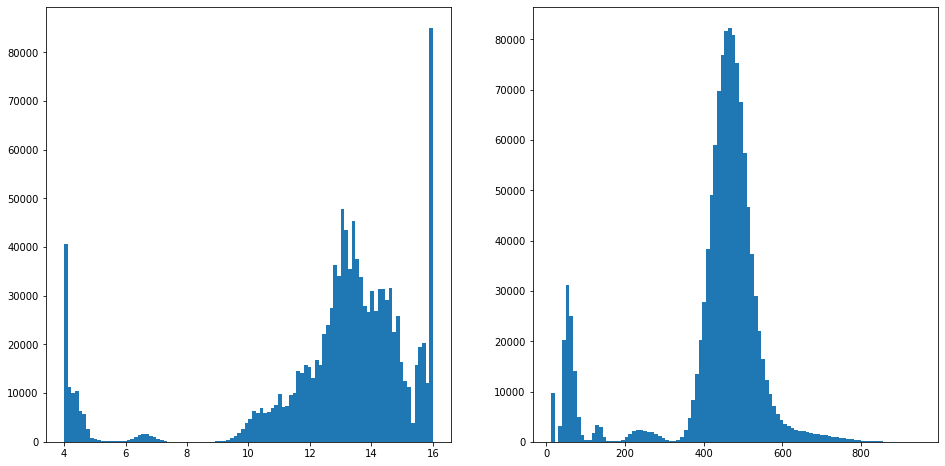

In [ ]:
fig2 = plt.figure(figsize=(16, 8))
flat_list = list(np.concatenate(y[:,1,:]).flat)
flat_list3 = list(np.concatenate(y[:,0,:]).flat)
plt.subplot(1,2,1)
plt.hist(flat_list,bins = 100)
plt.subplot(1,2,2)
plt.hist(flat_list3,bins = 100)
# plt.plot(err_L2,'bo',markersize=0.5,label = 'L2 error')

* Normalize the power of Laplacian

In [ ]:
W1 = W.copy()
W1 = np.asarray(W1)
# print(np.asarray([[2,3],[4,7]])/5)
W1 = W1 / 1
W2 = W1.copy()
print(type(W))
lam,v = np.linalg.eig(W1)
print(lam[0])
for i in range(5):
  W1 = np.matmul(W1,W2) / np.max(np.matmul(W1,W2))
  # print(W1)
  lam,v = np.linalg.eig(W1)
  print(lam[0])#/10**(i+1))

<class 'numpy.ndarray'>
10.391198194095512
1.1997444434330227
1.219576528758643
1.229596341419751
1.2352295835641847
1.2386748374057452


In [ ]:
def numparam(in_feats,out_feats): return 4*476+in_feats*out_feats+out_feats
indexes=[1,10,15,15,10,10,1]
total=0
for temp in range(len(indexes)-1):
  total+=numparam(indexes[temp],indexes[temp+1])
print(total)

12130


In [ ]:
from torch.autograd import Variable
# One layer Graph convolution from nodes to edges
class Graph_convolution_v2v_W(nn.Module):
    def __init__(self,in_features,out_features,W,n,bias=True):
        super(Graph_convolution_v2v_W,self).__init__()
        self.register_buffer('w',torch.from_numpy(W.transpose()).float())
        self.register_buffer('n0',torch.tensor(n))
        self.mapping=nn.Parameter(torch.Tensor(n,W.shape[0],W.shape[1]))
        torch.nn.init.xavier_uniform_(self.mapping.data)
        self.scale0=nn.Parameter(torch.Tensor(out_features,in_features))
        torch.nn.init.xavier_uniform_(self.scale0.data)
        self.scale=nn.Parameter(torch.Tensor(n-1,out_features,out_features))
        torch.nn.init.xavier_uniform_(self.scale.data)
        self.bias=nn.Parameter(torch.Tensor(out_features,1))
        torch.nn.init.xavier_uniform_(self.bias.data)

    def forward(self,input):
        h=torch.mul(self.mapping[0,:,:],self.w) # element-wise
        # print(h.shape,input.shape)
        h=torch.matmul(input,h) # transpose due to batch generator 
        # print(h.shape,self.scale0.shape)
        h=torch.matmul(self.scale0,h)
        for i in range(self.n0 - 1):
          W1 = torch.matrix_power(self.w,i+2)/torch.max(torch.matrix_power(self.w,i+2))
          h1=torch.mul(self.mapping[i,:,:],W1)
          h=torch.matmul(h,h1) # transpose due to batch generator 
          h=torch.matmul(self.scale[i,:,:],h)
        return h+self.bias 

# GNN using DGL v2v graph convolution and our own v2e graph convolution
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, W, num_bus, n_hop):
        super(GCN, self).__init__()
        self.conv_v2v1=Graph_convolution_v2v_W(in_feats,hidden_size[0],W,n_hop)
        self.conv_v2v2=Graph_convolution_v2v_W(hidden_size[0],hidden_size[1],W,n_hop)
        self.conv_v2v3=Graph_convolution_v2v_W(hidden_size[1],hidden_size[2],W,n_hop)
        self.conv_v2v4=Graph_convolution_v2v_W(hidden_size[2],hidden_size[3],W,n_hop)
        self.conv_v2v5=Graph_convolution_v2v_W(hidden_size[3],hidden_size[4],W,n_hop)
        self.conv_v2v6=Graph_convolution_v2v_W(hidden_size[4],hidden_size[5],W,n_hop)
        # self.conv_v2v7=Graph_convolution_v2v_W(hidden_size[5],hidden_size[6],W,n_hop)
        # self.conv_v2v8=Graph_convolution_v2v_W(hidden_size[6],hidden_size[7],W,n_hop)
        self.lin_output = nn.Linear(num_bus,num_bus)
         
    def forward(self, inputs):
        # m = nn.ELU()
        # m = nn.LeakyReLU()
        # m = nn.Tanh()
        m = nn.ReLU()
        h=self.conv_v2v1(inputs)
        h=m(h)
        h=self.conv_v2v2(h)
        h=m(h)
        h=self.conv_v2v3(h)
        h=m(h)
        h=self.conv_v2v4(h)
        h=m(h)
        h=self.conv_v2v5(h)
        h=m(h)
        h=self.conv_v2v6(h)
        h=m(h)
        # h=torch.relu(h)
        h = self.lin_output(h)
        # time.sleep(5)
        return h
n_bus=x.shape[0]
# w_params=[10,15,10,1]
w_params=[5,10,10,5,5,2]
n_hop = 2
# W = W / 10 # normalize
net=GCN(6,w_params,W,n_bus, n_hop) # Laplacian
net=net.to(device)

# set loss_func & optimizer

optimizer=torch.optim.Adam(net.parameters())
loss_optm=[]
loss_val=[]
print(net)
print('number of params: %d'%(sum(temp.numel() for temp in net.parameters() if temp.requires_grad)))

GCN(
  (conv_v2v1): Graph_convolution_v2v_W()
  (conv_v2v2): Graph_convolution_v2v_W()
  (conv_v2v3): Graph_convolution_v2v_W()
  (conv_v2v4): Graph_convolution_v2v_W()
  (conv_v2v5): Graph_convolution_v2v_W()
  (conv_v2v6): Graph_convolution_v2v_W()
  (lin_output): Linear(in_features=118, out_features=118, bias=True)
)
number of params: 181711


In [ ]:
# Number of parameters in net
n_params = 0
n_params_trainable = 0
for temp in net.parameters():
    # print(temp.shape[0])
    # print(temp.shape)
    n_params += temp.numel()
    if abs(temp.shape[0] - n_bus) > 0:
      n_params_trainable += temp.shape[0] * temp.shape[1]
    else:
      n_params_trainable += n_bus + 2 * n_line
print('Number of GNN parameters:',n_params)
print('Number of effective GNN parameters:',n_params_trainable)

Number of GNN parameters: 181711
Number of effective GNN parameters: 2735


In [ ]:
# threshold function for p_g
class my_gen_pred_binary(nn.Module):
  def __init__(self):
    super(my_gen_pred_binary,self).__init__()
  def forward(self,x,thresh):
    # thresh=torch.tensor(thresh).double()
    # print(thresh,thresh.dtype)
    # print(x.dtype,x)
    right_thresh=torch.tensor(thresh).double()
    left_thresh=torch.tensor(0).double()
    x=x.double()


    # output=torch.where(x<left_thresh,0.,x)
    # output=torch.where(output>right_thresh,right_thresh,output)

    # 1st layer
    output = torch.sigmoid(left_thresh - x)
    output = torch.mul(output,left_thresh - x) + x
    # 2nd layer
    output = torch.sigmoid(output - right_thresh)
    output = torch.mul(output,output - right_thresh) + right_thresh

    # output=torch.where(output*output<thresh*thresh,output/thresh,output)
    return output

In [ ]:
# cell=my_gen_pred_binary()
# test_tensor=torch.tensor(np.asarray([[[-1.5,-1.0],[-0.5,0.0]],[[0.5,1.0],[1.5,2]]]))#.double()
# output=cell(test_tensor,0.97)
# print(output)

In [ ]:
## define f-feasibility regularizer 

gen_pred_binary_cell = my_gen_pred_binary() # threshold function
def f_feas_reg(train_batch,pred_label,binary_thres,S,f_max):
  # train_batch,pred_label in device
  # params.to(device)

  # train_batch[:,2,:] # generator limit
  label1 = torch.squeeze(pred_label,1).transpose(0,1) # LMP: 118*batch 
  # train_batch[:,1,:] # generator cost
  p_max=train_batch[:,0,:].transpose(0,1) - train_batch[:,1,:].transpose(0,1)
  # p_max=train_batch[:,2,:].transpose(0,1)
  quadratic_b=train_batch[:,4,:].transpose(0,1)
  quadratic_a=train_batch[:,5,:].transpose(0,1)

  quadratic_center=(label1-quadratic_b)/(quadratic_a+1e-10)/2
  # profit = label1 - train_batch[:,1,:].transpose(0,1) # profit

  gen_pred_binary = gen_pred_binary_cell(quadratic_center,p_max)
  p_inj=gen_pred_binary
  # p_inj = torch.mul(gen_pred_binary,train_batch[:,2,:].transpose(0,1)) # p_g
  # nodal injection = gen - load
  # bus_inj = p_inj - train_batch[:,0,:].transpose(0,1) #???
  bus_inj = p_inj + train_batch[:,1,:].transpose(0,1)
  f = torch.matmul(S,bus_inj)

  # f=torch.abs(f)
  # # do not use torch.max
  # f_penalty=torch.where(f>f_max,f-f_max,0.)

  # sigmoid
  f_penalty = torch.sigmoid(f-f_max) + torch.sigmoid(-f-f_max)



  # f_penalty = torch.max(f - f_max,0) # linear penalty
  # f_penalty = torch.exp(f - f_max) - 1 # exponential penalty
  return f_penalty


# define loss function
loss_func=nn.MSELoss()
def my_loss_func(pred,label,W1,train_batch,S,f_max):
  lmda1=torch.from_numpy(np.array([1])).to(device) # L_2
  lmda2=torch.from_numpy(np.array([0.01])).to(device) # L_inf
  # lmda3=torch.from_numpy(np.array([0.02])).to(device) # locality
  lmda4=torch.from_numpy(np.array([0.1])).to(device) # f-feasibility

  binary_thres = 0.97 # P_g threshold for 0
  binary_thres = torch.tensor(binary_thres).to(device)
  # print(pred.shape,label.shape)
  # [256, 2, 118]
  mse_v = loss_func(pred[:,1,:],label[:,1,:]) 
  mse_pi = loss_func(pred[:,0,:],label[:,0,:])
  linf_v = (pred[:,1,:]-label[:,1,:]).norm(p=float('inf'))
  linf_pi = (pred[:,0,:]-label[:,0,:]).norm(p=float('inf'))
  # locality = torch.matmul(torch.matmul(pred,W1),pred.transpose(1,2))
  f_penalty = f_feas_reg(train_batch,pred[:,0,:],binary_thres,S,f_max*0.9) # scaled for S_ij
  # print(pred.shape,pred.transpose(1,2).shape)
  return lmda1*mse_v + lmda1*mse_pi + lmda2*linf_v + lmda2*linf_pi +lmda4*torch.sum(f_penalty) #+lmda3*torch.mean(locality) # mean/sum over batch

In [ ]:
!nvidia-smi

Sat Feb 19 17:09:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W /  70W |   1364MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
## Training
t0=time.time()
max_epochs=200
eval_epoch=5

# earlystopping
tolerance=10
min_delta=1e-3
previous=0

W_tensor = torch.from_numpy(W).float().to(device)
for epoch in range(max_epochs):
  # training loop
  train_loss=0.0
  for local_batch,local_label in training_generator:
    optimizer.zero_grad() # clear the past gradient
    # print(local_batch.shape)
    # # print(local_batch)
    # print(local_label.shape)
    logits=net(local_batch)
    # print(logits.shape,local_label.shape)
    # xx
    loss=my_loss_func(logits,local_label,W_tensor,local_batch,S,f_max)
    loss.backward()
    train_loss+=loss.item()
    optimizer.step() # update parameters of net
  loss_optm.append(train_loss/len(training_generator.dataset))
  print("Epoch %d | Training loss: %.4f"%(epoch,train_loss/len(training_generator.dataset)))
  # eval
  if (epoch+1)%eval_epoch==0:
    net.eval()
    eval_loss=0.0
    for eval_batch,eval_label in validation_generator:
      eval_batch,eval_label=eval_batch.to(device),eval_label.to(device)
      logits=net(eval_batch)
      loss=my_loss_func(logits,eval_label,W_tensor,eval_batch,S,f_max)
      eval_loss+=loss.item()
    eval_avg=eval_loss/len(validation_generator.dataset)
    if (epoch==0): previous=eval_avg
    else:
      if previous-eval_avg<min_delta: tolerance-=1
      if tolerance==0: break
      previous=eval_avg
    print("Epoch %d | Eval loss: %.4f" % (epoch, eval_avg))
    loss_val.append([epoch, eval_loss/len(validation_generator.dataset)])
    net.train()
  # validation loop
  with torch.set_grad_enabled(False):
      pass
t1=time.time()
print("Training time:%.4fs"%(t1-t0))
# path='/content/drive/MyDrive/gnn/dnn_pytorch/sample_gnn_ac118.pickle'
# torch.save(net.state_dict(),path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Epoch 0 | Training loss: 816.1337
Epoch 1 | Training loss: 809.8229
Epoch 2 | Training loss: 801.0862
Epoch 3 | Training loss: 790.3982
Epoch 4 | Training loss: 774.6539
Epoch 4 | Eval loss: 756.7311
Epoch 5 | Training loss: 579.9733
Epoch 6 | Training loss: 117.7113
Epoch 7 | Training loss: 46.2806
Epoch 8 | Training loss: 22.2634
Epoch 9 | Training loss: 12.4478
Epoch 9 | Eval loss: 9.8543
Epoch 10 | Training loss: 8.3778
Epoch 11 | Training loss: 6.7776
Epoch 12 | Training loss: 6.1282
Epoch 13 | Training loss: 5.8553
Epoch 14 | Training loss: 5.7267
Epoch 14 | Eval loss: 5.7431
Epoch 15 | Training loss: 5.6079
Epoch 16 | Training loss: 5.5299
Epoch 17 | Training loss: 5.5004
Epoch 18 | Training loss: 5.4552
Epoch 19 | Training loss: 5.4507
Epoch 19 | Eval loss: 5.4951
Epoch 20 | Training loss: 5.3778
Epoch 21 | Training loss: 5.4187
Epoch 22 | Training loss: 5.3759
Epoch 23 | Training loss: 5.3484
Epoch 24 | Training loss: 5.2837
Epoch 24 | Eval loss: 5.3315
Epoch 25 | Training los

In [ ]:
# logits[0:2,:,:]
W
path='/content/drive/MyDrive/gnn/dnn_pytorch/sample_gnn_ac118.pickle'
# torch.save(net.state_dict(),path)

In [ ]:
!nvidia-smi

Sat Feb 19 17:11:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    29W /  70W |   1472MiB / 15109MiB |     28%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# print(len(loss_val))
# print(loss_val[0][0])
# # print(val_plt)
# print(logits.shape,eval_label.shape)

35


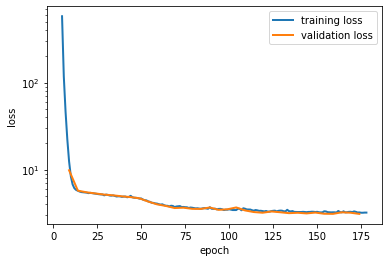

In [ ]:
import matplotlib.pyplot as plt

val_len = len(loss_val)
print(val_len)
val_plt = np.zeros((2,val_len))
for i in range(val_len):
  val_plt[0,i] = loss_val[i][0]
  val_plt[1,i] = loss_val[i][1]

plt.figure()
plot_idx = np.arange(np.size(loss_optm))
# plt.plot(plot_idx,loss_optm,lw=2,label='training loss')
# plt.plot(val_plt[0,:],val_plt[1,:],lw=2,label='validation loss')
plt.plot(plot_idx[5:-1],loss_optm[5:-1],lw=2,label='training loss')
plt.plot(val_plt[0,1:],val_plt[1,1:],lw=2,label='validation loss')
plt.yscale("log")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show(block=False)

# from datetime import datetime
# now=datetime.now()
# timestamp=now.strftime('%Y%d%m%H%M%S')
# path='/content/drive/MyDrive/gnn/dnn_pytorch/gnn_%s.pickle'%(timestamp)
# # torch.save(net.state_dict(),path)
# path='/content/drive/MyDrive/gnn/dnn_pytorch/gnn_118_%s.pickle'%(timestamp)
# torch.save(net.state_dict(),path)
# path = '/content/drive/MyDrive/gnn/dnn_pytorch/gnn_118_20212205071835.pickle'
# net.load_state_dict(torch.load(path))

# Evaluate the model w/ validation set

In [ ]:
# local_batch, local_labels = local_batch.to(device), local_labels.to(device)
# print(local_batch.shape)
# x_test_feed = x_test_feed.unsqueeze_(-1).transpose(1,2)
# print(x_test_feed.shape)

# print(local_batch.shape)

In [ ]:
# validation_set = Dataset(features=x_test, labels=y_test)
# validation_generator = torch.utils.data.DataLoader(validation_set, **params)
# for local_batch, local_labels in validation_generator:
#   # Transfer to GPU
#   local_batch, local_labels = local_batch.to(device), local_labels.to(device)
#   logits = net(local_batch)

n_test = 2000

x_test_feed = torch.from_numpy(np.transpose(x_test)).float()
x_test_feed = x_test_feed#.transpose(1,2)
x_test_feed = x_test_feed.to(device)
print('Validation dataset size:',x_test_feed.shape)
print('Number of validation set: ',n_test)
# y_pred = np.zeros((x_test_feed.shape))
# for i in range(n_test):
#   y_pred[i,:] = net(x_test_feed[i,:])
y_pred = net(x_test_feed)

Validation dataset size: torch.Size([2000, 6, 118])
Number of validation set:  2000


* Visualization




 - Visualize errors

In [ ]:
y_pred1 = y_pred.cpu().detach()
y_pred1 = torch.squeeze(y_pred1,1).numpy().transpose()
print(y_test.shape)

(118, 2, 2000)


In [ ]:
# recover the original p.u. scale
y_pred1 = y_pred1 / 100 + 0.9
y_test = y_test / 100 + 0.9

print(y_test.shape,y_pred1.shape)

(118, 2, 2000) (118, 2, 2000)


In [ ]:
# for i in range(5):
#   print('sample',i)
#   print(y_test[:,i])
#   print(y_pred1[:,i])

In [ ]:
n_test = np.size(y_test,2)
err_L2 = np.zeros(n_test)
err_Linf = np.zeros(n_test)
for i in range(n_test):
  err_L2[i] = np.linalg.norm(y_test[:,0,i] - y_pred1[:,0,i]) / np.linalg.norm(y_test[:,0,i])
  err_Linf[i] = np.max(np.abs(y_test[:,0,i] - y_pred1[:,0,i])) / np.max(np.abs(y_test[:,0,i]))

err_L2_v = np.zeros(n_test)
err_Linf_v = np.zeros(n_test)
for i in range(n_test):
  err_L2_v[i] = np.linalg.norm(y_test[:,1,i] - y_pred1[:,1,i]) / np.linalg.norm(y_test[:,1,i])
  err_Linf_v[i] = np.max(np.abs(y_test[:,1,i] - y_pred1[:,1,i])) / np.max(np.abs(y_test[:,1,i]))

In [ ]:
print(err_L2.shape,err_Linf.shape)

(2000,) (2000,)


Price L2 mean: 0.04268878525400136 L_inf mean: 0.051382631756466776
Voltage L2 mean: 0.015517490731179563 L_inf mean: 0.09775871948170212


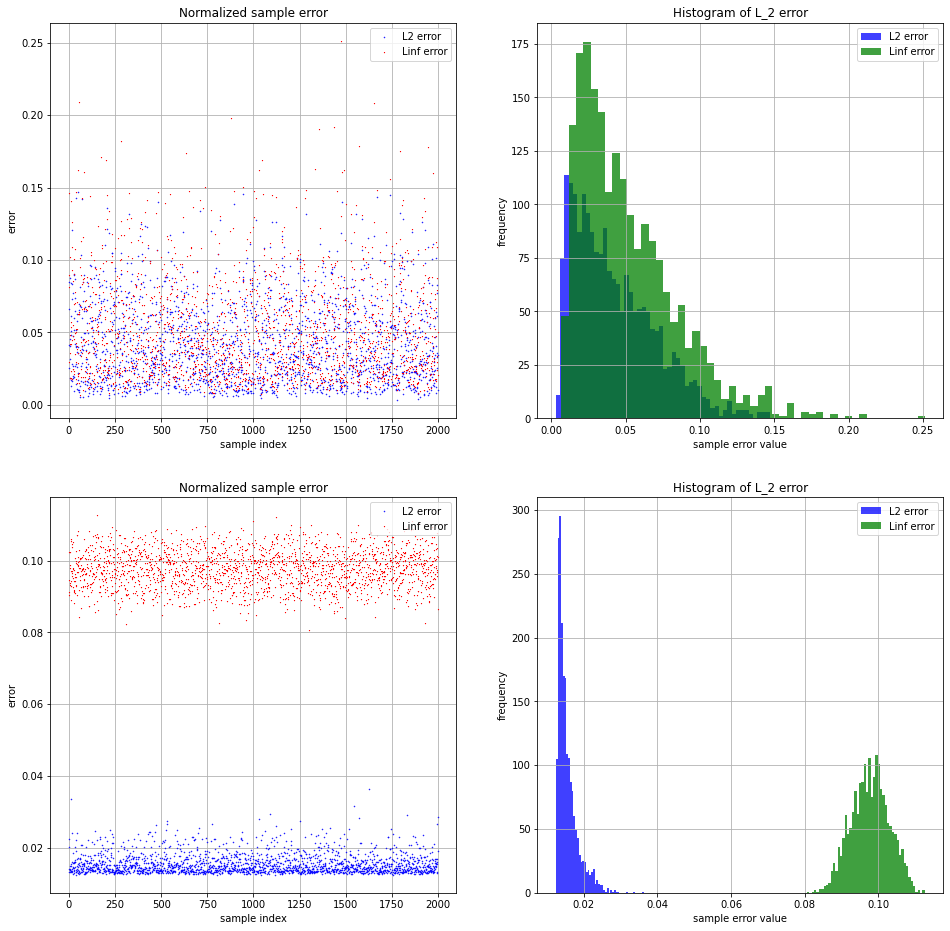

In [ ]:
err_L2_mean = np.mean(err_L2)
err_Linf_mean = np.mean(err_Linf)
print('Price L2 mean:', err_L2_mean,'L_inf mean:', err_Linf_mean )
err_L2_mean_v = np.mean(err_L2_v)
err_Linf_mean_v = np.mean(err_Linf_v)
print('Voltage L2 mean:', err_L2_mean_v,'L_inf mean:', err_Linf_mean_v )

fig2 = plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
# plt.hist(np.abs(ga),bins = 10)
plt.plot(err_L2,'bo',markersize=0.5,label = 'L2 error')
plt.plot(err_Linf,'r^',markersize=0.5,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample index')
plt.ylabel('error')
plt.title('Normalized sample error')
plt.grid(True)
# error histogram
plt.subplot(2, 2, 2)
plt.hist(err_L2, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
plt.hist(err_Linf, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)

plt.subplot(2, 2, 3)
# plt.hist(np.abs(ga),bins = 10)
plt.plot(err_L2_v,'bo',markersize=0.5,label = 'L2 error')
plt.plot(err_Linf_v,'r^',markersize=0.5,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample index')
plt.ylabel('error')
plt.title('Normalized sample error')
plt.grid(True)
# error histogram
plt.subplot(2, 2, 4)
plt.hist(err_L2_v, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
plt.hist(err_Linf_v, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)

plt.show()

(118, 2000) (118, 2000)
1.06 0.94
1.1092336 0.900188


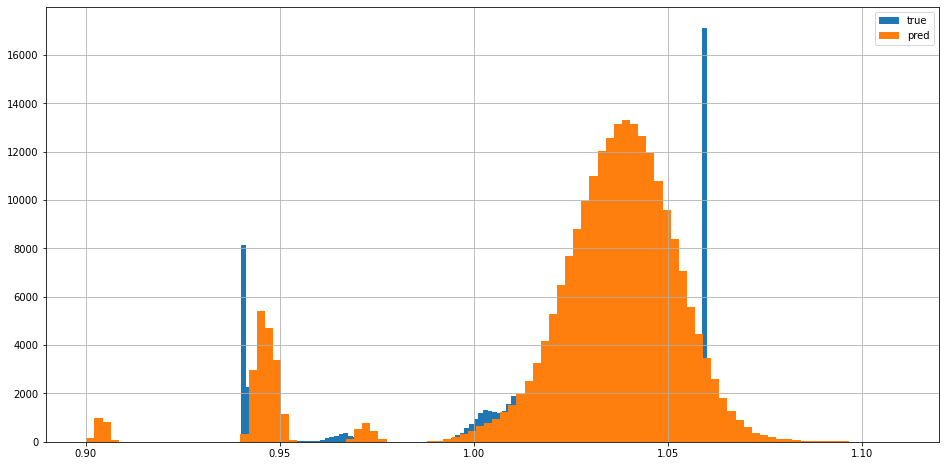

In [ ]:
print(y_pred1[:,1,:n_test].shape,y_test[:,1,:n_test].shape)
print(np.max(y_test[:,1,:n_test]),np.min(y_test[:,1,:n_test]))
print(np.max(y_pred1[:,1,:n_test]),np.min(y_pred1[:,1,:n_test]))

fig3 = plt.figure(figsize=(16, 8))
flat_list1 = list(np.concatenate(y_test[:,1,:n_test]).flat)
flat_list2 = list(np.concatenate(y_pred1[:,1,:n_test]).flat)
plt.hist(flat_list1,bins = 100,label = 'true')
plt.hist(flat_list2,bins = 100,label = 'pred')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

2000 L2 mean: 0.04268878525400136 2000 L_inf mean: 0.051382631756466776


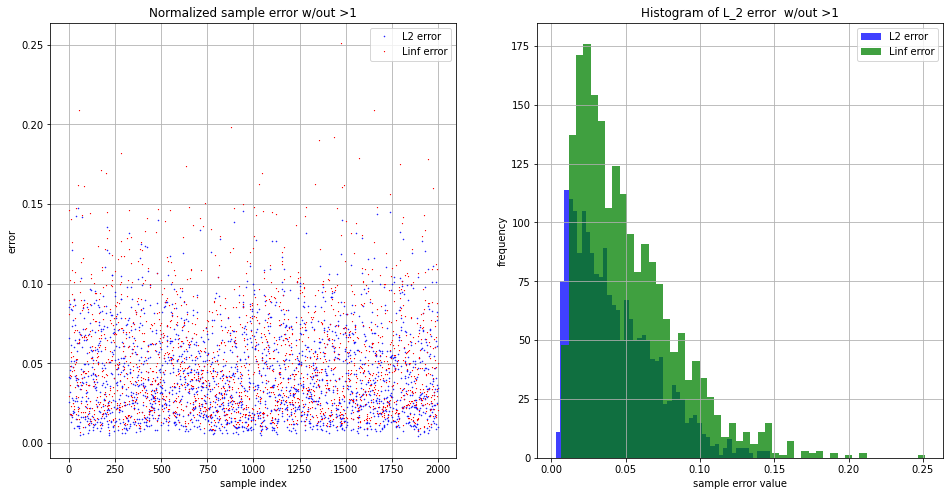

In [ ]:
err_l2_new = [i for i in err_L2 if i < 1]
err_linf_new = [i for i in err_Linf if i < 1]
print(len(err_l2_new),'L2 mean:', np.mean(err_l2_new),len(err_linf_new),'L_inf mean:', np.mean(err_linf_new) )

fig2 = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
# plt.hist(np.abs(ga),bins = 10)
plt.plot(err_l2_new,'bo',markersize=0.5,label = 'L2 error')
plt.plot(err_linf_new,'r^',markersize=0.5,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample index')
plt.ylabel('error')
plt.title('Normalized sample error w/out >1')
plt.grid(True)
# error histogram
plt.subplot(1, 2, 2)
plt.hist(err_l2_new, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
plt.hist(err_linf_new, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error  w/out >1')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

In [ ]:
print(x_train.shape)
# print(x_train[:,:,1].transpose())
# print(np.max(gen_limit0),np.min(err_linf_new))

(118, 6, 8000)


In [ ]:
# y_test_copy
# y_pred1[:,index]

# Predict generation using $\pi$
* Using predicted $\pi$ and find the active constraints in $p_G(i)$
* For inactive $p_G(i)$ consider other methods like power flow balance

In [ ]:
gen_limit0 = x[:,4,:].copy() # lin cost
print(gen_limit0.shape)

gen_idx = []
gen_idx = np.arange(n_bus)
# for i in range(n_bus):
#   if gen_limit0[i,0] > 0:
#     gen_idx.append(i)
print(type(gen_idx),len(gen_idx),gen_idx)

(118, 10000)
<class 'numpy.ndarray'> 118 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117]


In [ ]:
# # get the generator index
# # generator cost data
# gen_cost0
# # generator limit data
# gen_limit0
# # LMP data
# lmp_data
# # generation data
# gen_data

load_data = x.copy()
load_data = load_data[:,:]
print(load_data.shape)
n_sample = np.size(load_data,2)

# predict the corredponding LMP
x_val_feed = torch.from_numpy(np.transpose(load_data)).float()
batch_size=2000
y_pred1=[]
with torch.no_grad():
  for idx in range(0,x_val_feed.shape[0],batch_size):
    current_batch=x_val_feed[idx:idx+batch_size]
    current_batch=current_batch.to(device)
    current_y=net(current_batch)
    current_y=current_y.cpu().detach()
    current_y=torch.squeeze(current_y,1).numpy().tolist()
    y_pred1+=current_y
y_pred1=np.array(y_pred1).transpose()

print('Dataset size:',x_val_feed.shape)
print('Number of validation points:: ',n_sample)

# net1 = net.cpu()
# y_pred = net1(x_val_feed)

# y_pred1 = y_pred.cpu().detach()
print('output size',y_pred1.shape)
# y_pred1 = torch.squ[]eeze(y_pred1,1).numpy().transpose()
print('reshaped size',y_pred1.shape)

# load_data = x.copy()
# print(load_data.shape)
# n_sample = np.size(load_data,2)

# x_val_feed = torch.from_numpy(np.transpose(load_data)).float()
# x_val_feed = x_val_feed.to(device)

# print('Dataset size:',x_val_feed.shape)
# print('Number of validation points:: ',n_sample)
# y_pred = net(x_val_feed) # predict the corredponding LMP

# y_pred1 = y_pred.cpu().detach()
# print('output size',y_pred1.shape)
# y_pred1 = torch.squeeze(y_pred1,1).numpy().transpose()
# print('reshaped size',y_pred1.shape)

(118, 6, 10000)
Dataset size: torch.Size([10000, 6, 118])
Number of validation points::  10000
output size (118, 2, 10000)
reshaped size (118, 2, 10000)


* Save results

In [ ]:
import pickle

In [ ]:
# dataset = {'lmp_pred': y_pred1, 'lmp_true': lmp_data}
# print('Pred:',y_pred1.shape,'True:',lmp_data.shape)

# file_name = 'dc118_lmp_prediction_p10'
# file_path = 'drive/My Drive/gnn/data/results/'
# file_dir = file_path + file_name + '.pickle'
# outfile = open(file_dir, 'wb')
# pickle.dump(dataset, outfile)
# outfile.close()

In [ ]:
gen_cost0 = x[:,4,:].copy()
lmp_data = y[:,0,:].copy()

quadratic_a = x[:,5,:].copy()

profit_pred = y_pred1[:,0,:] - gen_cost0
print(np.min(np.abs(profit_pred)))

profit_true = lmp_data - gen_cost0
print(np.min(np.abs(profit_true)))

profit_pred=(y_pred1[:,0,:]-gen_cost0)/(quadratic_a+1e-10)/2
profit_true=(lmp_data-gen_cost0)/(quadratic_a+1e-10)/2
print(np.min(np.abs(profit_pred)))
print(np.min(np.abs(profit_true)))

0.7159849472045892
0.784000000000006
5.481826217693347
0.24221453285700786


(118, 10000) (118, 10000)
0.051578279587374556


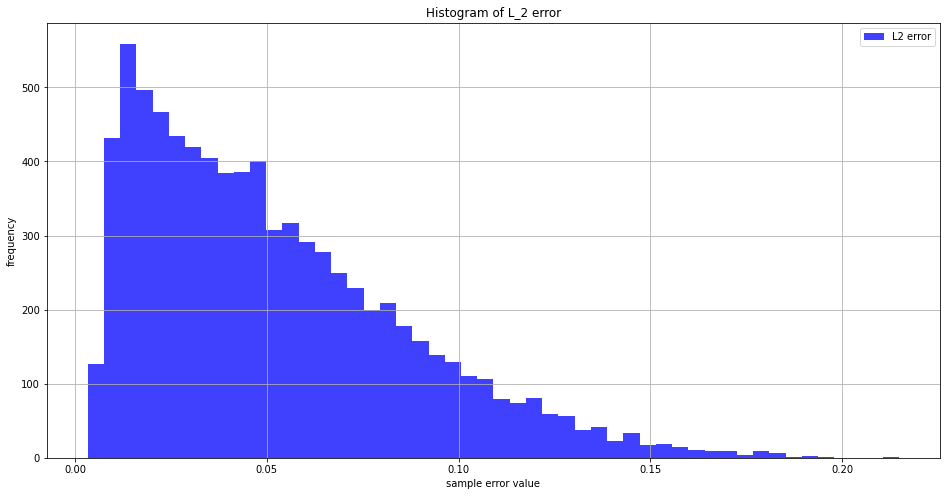

In [ ]:
print(profit_pred.shape,profit_true.shape)
profit_err = profit_true - profit_pred

profit_err_l2 = np.zeros([8000,1])

for i in range(8000):
  profit_err_l2[i] = np.linalg.norm(profit_err[:,i])/np.linalg.norm(profit_true[:,i])
print(np.mean(profit_err_l2))

fig5 = plt.figure(figsize=(16, 8))
# error histogram
plt.hist(profit_err_l2, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
# plt.hist(err_linf_new, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

In [ ]:
p_pred_sort = np.reshape(profit_pred,n_bus*n_sample)
p_true_sort = np.reshape(profit_true,n_bus*n_sample)
print(p_pred_sort.shape)

(1180000,)


In [ ]:
print(np.min(p_pred_sort),np.min(p_true_sort))

5.481826217693347 -2.9391182643149665


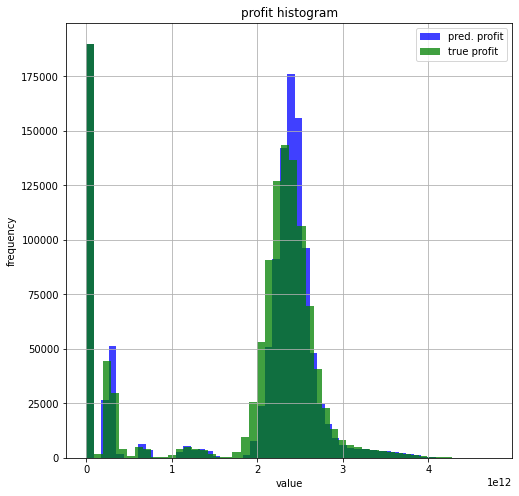

In [ ]:
fig2 = plt.figure(figsize=(8, 8))
plt.hist(p_pred_sort, bins = 50, facecolor='b', alpha=0.75,label = 'pred. profit')
plt.hist(p_true_sort, bins = 50, facecolor='g', alpha=0.75,label = 'true profit')
plt.legend(loc="upper right")
plt.xlabel('value')
plt.ylabel('frequency')
plt.title('profit histogram')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

In [ ]:
# gen_pred_binary = np.zeros((len(gen_idx),n_sample))
# gen_true_binary = np.zeros((len(gen_idx),n_sample))
# print(gen_pred_binary.shape)

# binary_thres = 2.5
# binary_thres_true = 1e-5

# for i in range(n_sample):
#   for j in range(len(gen_idx)):
#     # predicted generator limit
#     if profit_pred[gen_idx[j],i] > binary_thres:
#       gen_pred_binary[j,i] = 1
#     elif profit_pred[gen_idx[j],i] < 0:
#       gen_pred_binary[j,i] = 0
#     else:
#       # gen_pred_binary[j,i] = (profit_pred[gen_idx[j],i] + binary_thres) / (2*binary_thres)
#       gen_pred_binary[j,i] = (profit_pred[gen_idx[j],i]) / (binary_thres)
#     # true generator limit
#     if profit_true[gen_idx[j],i] > binary_thres_true:
#       gen_true_binary[j,i] = 1
#     elif profit_true[gen_idx[j],i] < 0:
#       gen_true_binary[j,i] = 0
#     else:
#       gen_true_binary[j,i] = 0.5

# gen_binary_err = np.abs(gen_true_binary - gen_pred_binary)
# print('max binary error:',np.max(gen_binary_err))
# # count the wrong entries
# gen_binary_err_ct = np.sum(gen_binary_err)
# gen_binary_err_ratio = gen_binary_err_ct / (len(gen_idx)*n_sample)
# print('Binary accuracy:',1-gen_binary_err_ratio)

In [ ]:
print(gen_limit0.shape)
print(np.transpose(x_test).shape,np.transpose(load_data).shape)

(118, 10000)
(2000, 6, 118) (10000, 6, 118)


 # Test flow feasibility

In [ ]:
x[:,2,:].shape
profit_pred.shape
# n_sample

(118, 10000)

In [ ]:
# x = [load, gen_cost, gen_lim]

# binary_thres = 0.97
binary_thres_true = 1e-5
# binary_thres = gen_limit0
binary_thres = x[:,0,:].copy() # upper
binary_thres_lo = x[:,1,:].copy() # lower

gen_pred_binary_full = np.zeros((n_bus,n_sample))
gen_true_binary_full = np.zeros((n_bus,n_sample))
# print(gen_pred_binary.shape,profit_pred.shape,gen_pred_binary_full.shape)

# x[:,2,:] # p_max

# ## generator injection
# for i in range(n_sample):
#   for j in range(len(gen_idx)):
#     # predicted generator limit
#     if profit_pred[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
#       gen_pred_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
#     elif profit_pred[gen_idx[j],i] < 0:
#       gen_pred_binary_full[gen_idx[j],i] = 0
#     else:
#       gen_pred_binary_full[gen_idx[j],i] = profit_pred[gen_idx[j],i]
#     # true generator limit
#     if profit_true[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
#       gen_true_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
#     elif profit_true[gen_idx[j],i] < 0:
#       gen_true_binary_full[gen_idx[j],i] = 0
#     else:
#       gen_true_binary_full[gen_idx[j],i] = profit_true[gen_idx[j],i]

## nodal injection
# gen_limit0 = x[:,2,:].copy()
for i in range(n_sample):
  for j in range(len(gen_idx)):
    # predicted generator limit
    if profit_pred[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
      gen_pred_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
    elif profit_pred[gen_idx[j],i] < binary_thres_lo[gen_idx[j],i]:
      gen_pred_binary_full[gen_idx[j],i] = binary_thres_lo[gen_idx[j],i]
    else:
      gen_pred_binary_full[gen_idx[j],i] = profit_pred[gen_idx[j],i]
    # true generator limit
    if profit_true[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
      gen_true_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
    elif profit_true[gen_idx[j],i] < binary_thres_lo[gen_idx[j],i]:
      gen_true_binary_full[gen_idx[j],i] = binary_thres_lo[gen_idx[j],i]
    else:
      gen_true_binary_full[gen_idx[j],i] = profit_true[gen_idx[j],i]


# injection by generators
# gen_inj = np.multiply(gen_pred_binary_full,gen_limit0)
# gen_inj_true = np.multiply(gen_true_binary_full,gen_limit0)
gen_inj=gen_pred_binary_full
gen_inj_true=gen_true_binary_full
# nodal injection
load0 = -x[:,1,:].copy() # load file
p_inj = gen_inj #- load0
p_inj_true = gen_inj_true #- load0

In [ ]:
# load0 = x[:,0,:].copy()
print(np.sum(p_inj),np.sum(gen_inj_true))
print(np.sum(p_inj),np.sum(load0),np.sum(gen_inj))

4181304.4535603025 2764601.835122853
4181304.4535603025 43260060.56350001 4181304.4535603025


## injection accuracy

(118, 10000) (118, 10000)
mean p_inj l2 err: 0.08607141536352488


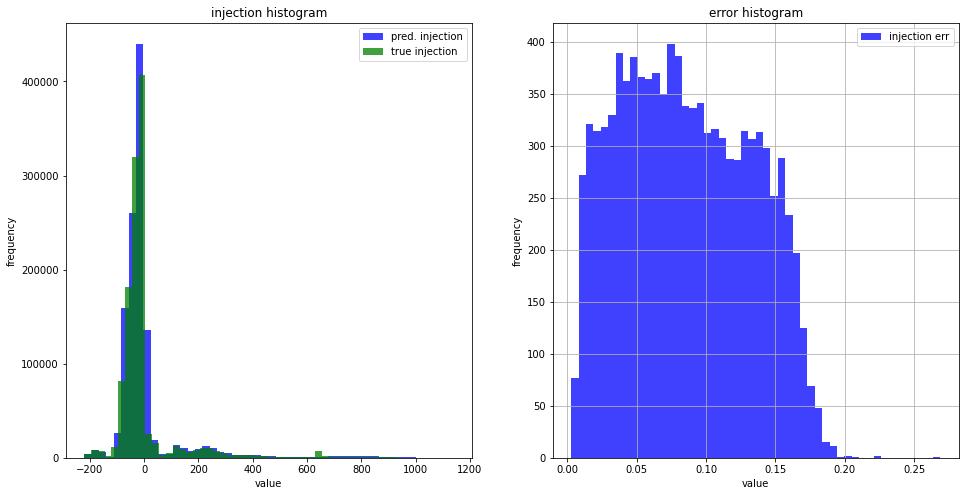

In [ ]:
print(p_inj_true.shape,p_inj.shape)

p_inj_true_sort = np.reshape(p_inj_true,n_bus*n_sample)
p_inj_sort = np.reshape(p_inj,n_bus*n_sample)

p_err = np.zeros(n_sample)
for i in range(n_sample):
  p_err[i] = np.linalg.norm(p_inj_true[:,i]-p_inj[:,i]) / np.linalg.norm(p_inj_true[:,i])

print('mean p_inj l2 err:',np.mean(p_err))
fig3 = plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.hist(p_inj_sort, bins = 50, facecolor='b', alpha=0.75,label = 'pred. injection')
plt.hist(p_inj_true_sort, bins = 50, facecolor='g', alpha=0.75,label = 'true injection')
plt.legend(loc="upper right")
plt.xlabel('value')
plt.ylabel('frequency')
plt.title('injection histogram')
plt.subplot(1,2,2)
plt.hist(p_err, bins = 50, facecolor='b', alpha=0.75,label = 'injection err')
plt.legend(loc="upper right")
plt.xlabel('value')
plt.ylabel('frequency')
plt.title('error histogram')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

* Calculate flow

In [ ]:
n_line = np.size(S_isf,0)
flow_est = np.zeros((n_line,n_sample))
flow_est0 = np.zeros((n_line,n_sample))

f_binary = np.zeros((n_line,n_sample))
f_binary0 = np.zeros((n_line,n_sample))

# for i in range(n_sample):
flow_est = np.dot(S_isf,p_inj)
flow_est0 = np.dot(S_isf,p_inj_true)
# f_max
f_max_numpy = f_max.cpu().detach().numpy()
f_binary = (np.abs(flow_est)-f_max_numpy > 0)
f_binary0 = (np.abs(flow_est0)-f_max_numpy > 0)

In [ ]:
f_tot_sample = n_line * n_sample
print(np.sum(f_binary),np.sum(f_binary0))
print(np.sum(f_binary)/f_tot_sample,np.sum(f_binary0)/f_tot_sample)

16746 13334
0.009003225806451612 0.007168817204301075


In [ ]:
print(n_line,n_sample,flow_est.shape)

186 10000 (186, 10000)


In [ ]:
# soft threshold
f_err_est = np.abs(flow_est)-f_max_numpy
f_err_true = np.abs(flow_est0)-f_max_numpy

f_err_est = np.maximum(np.abs(flow_est)-f_max_numpy,0) # identify violations
f_err_true = np.maximum(np.abs(flow_est0)-f_max_numpy,0)

print(np.max(f_err_est),np.max(f_err_true))
print(np.max(f_err_est/f_max_numpy),np.max(f_err_true/f_max_numpy))

# a= np.asarray([[1,2,1],[2,2,1]])
# b = np.asarray([1,1,1])
# c = (a-b>0)
# print(c)
# print(np.sum(c))

143.27440474495984 39.64401431411352
0.9551626982997322 0.2642934287607568


In [ ]:
# f_binary_soft = (np.abs(flow_est)-f_max_numpy > 0.01*np.max(f_max_numpy))
# f_binary0_soft = (np.abs(flow_est0)-f_max_numpy > 0.01*np.max(f_max_numpy))
f_binary_soft = (np.abs(flow_est)-f_max_numpy > 0.1*(f_max_numpy))
f_binary0_soft = (np.abs(flow_est0)-f_max_numpy > 0.1*(f_max_numpy))
print(np.sum(f_binary_soft),np.sum(f_binary0_soft))
print(np.sum(f_binary_soft)/f_tot_sample,np.sum(f_binary0_soft)/f_tot_sample)

13137 10451
0.007062903225806451 0.005618817204301075


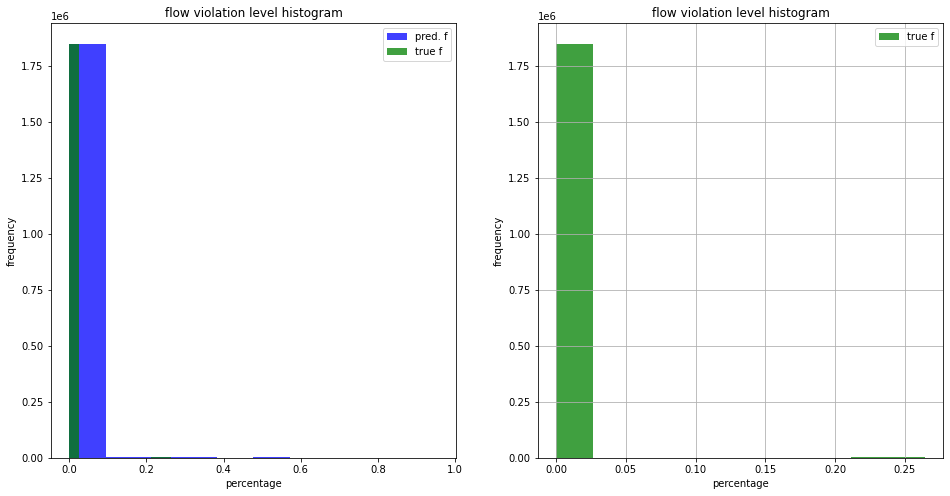

In [ ]:
f_pred_sort = np.reshape(f_err_est/f_max_numpy,n_line*n_sample)
f_true_sort = np.reshape(f_err_true/f_max_numpy,n_line*n_sample)

fig2 = plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.hist(f_pred_sort, bins = 10, facecolor='b', alpha=0.75,label = 'pred. f')
plt.hist(f_true_sort, bins = 10, facecolor='g', alpha=0.75,label = 'true f')
plt.legend(loc="upper right")
plt.xlabel('percentage')
plt.ylabel('frequency')
plt.title('flow violation level histogram')
plt.subplot(1,2,2)
plt.hist(f_true_sort, bins = 10, facecolor='g', alpha=0.75,label = 'true f')
plt.legend(loc="upper right")
plt.xlabel('percentage')
plt.ylabel('frequency')
plt.title('flow violation level histogram')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

In [ ]:
f_line = np.sum(f_binary,0)
f_samp = np.sum(f_binary,1)
print('max sample pred:',np.max(f_line))
print('max line pred:',np.max(f_samp))

f_line0  = np.sum(f_binary0,0)
f_samp0 = np.sum(f_binary0,1)
print('max sample true:',np.max(f_line0))
print('max line true:',np.max(f_samp0))

max sample pred: 3
max line pred: 9996
max sample true: 3
max line true: 10000


# Check objective optimality

In [ ]:
# gen_pred_binary_full = np.zeros((n_bus,n_sample))
# gen_true_binary_full = np.zeros((n_bus,n_sample))

# p_inj = gen_inj #- load0
# p_inj_true = gen_inj_true #- load0

# gen_cost0 = x[:,4,:].copy()
# # lmp_data = y.copy()

# quadratic_a = x[:,5,:].copy()
print(gen_cost0.shape)

(118, 10000)


0.09109928099555056


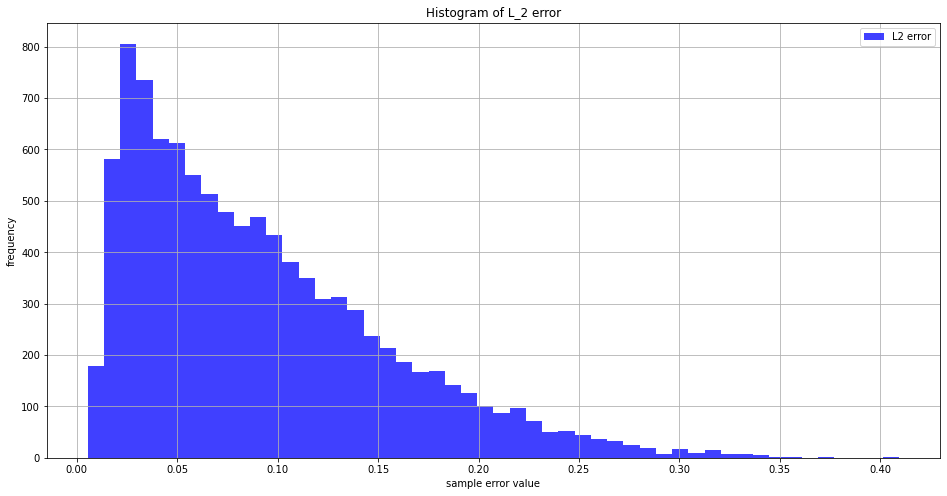

In [ ]:
gen_cost_pred = np.zeros((n_bus,n_sample))
gen_cost_true = np.zeros((n_bus,n_sample))
objective_err = np.zeros(n_sample)

gen_cost_pred = np.multiply(np.multiply(p_inj,p_inj),quadratic_a) + np.multiply(p_inj,gen_cost0)
gen_cost_true = np.multiply(np.multiply(p_inj_true,p_inj_true),quadratic_a) + np.multiply(p_inj_true,gen_cost0)

objective_err = np.sum(np.abs(gen_cost_true-gen_cost_pred),axis=0) / np.sum(gen_cost_true,axis=0)
print(np.mean(objective_err))

fig6 = plt.figure(figsize=(16, 8))
# error histogram
plt.hist(objective_err, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
# plt.hist(err_linf_new, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

In [ ]:
objective_err.shape

(10000,)

## injection accuracy

(118, 10000) (118, 10000)
mean p_inj l2 err: 0.08607141536352488


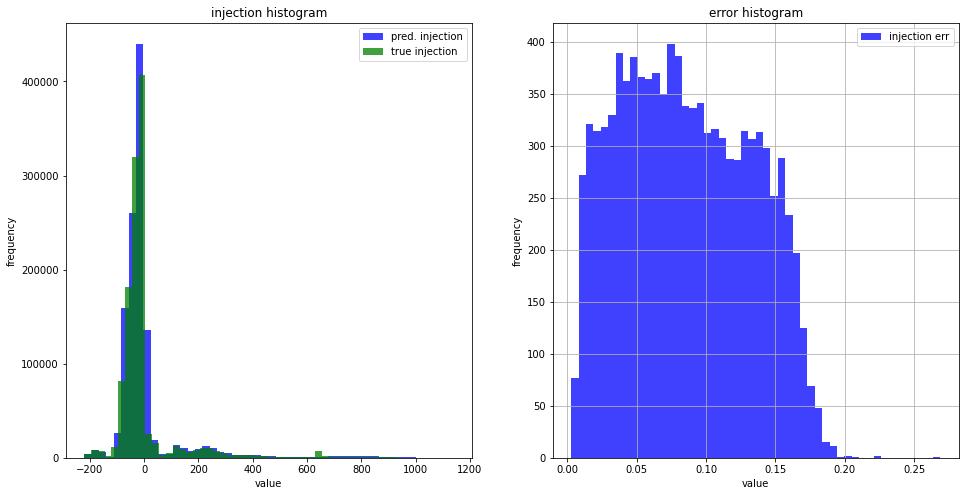

In [ ]:
print(p_inj_true.shape,p_inj.shape)

p_inj_true_sort = np.reshape(p_inj_true,n_bus*n_sample)
p_inj_sort = np.reshape(p_inj,n_bus*n_sample)

p_err = np.zeros(n_sample)
for i in range(n_sample):
  p_err[i] = np.linalg.norm(p_inj_true[:,i]-p_inj[:,i]) / np.linalg.norm(p_inj_true[:,i])

print('mean p_inj l2 err:',np.mean(p_err))
fig3 = plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.hist(p_inj_sort, bins = 50, facecolor='b', alpha=0.75,label = 'pred. injection')
plt.hist(p_inj_true_sort, bins = 50, facecolor='g', alpha=0.75,label = 'true injection')
plt.legend(loc="upper right")
plt.xlabel('value')
plt.ylabel('frequency')
plt.title('injection histogram')
plt.subplot(1,2,2)
plt.hist(p_err, bins = 50, facecolor='b', alpha=0.75,label = 'injection err')
plt.legend(loc="upper right")
plt.xlabel('value')
plt.ylabel('frequency')
plt.title('error histogram')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

# Test AC feasibility
* P in actual value, V in p.u.
* Use P to recover $\theta$, or solve $\theta$ and Q for PF
$$ Q_m = V_m \sum_{n=1}^N V_n \left(G_{mn}\sin\theta_{mn} - B_{mn}\cos\theta_{mn} \right) $$
calculate $Q_{mn}$ directly

In [ ]:
# p_inj (base all 100), p=B\theta, \theta_r = B_r^-1 p_r, ref bus is 69


In [ ]:
# Bbus and B_r inverse
filename1 = '/content/drive/MyDrive/gnn/data/data_118_quad/ieee118_Bbus.txt'
Bbus=pd.read_table(filename1,sep=',',header=None).to_numpy()
B_r = np.delete(Bbus,68,axis=0)
B_r = np.delete(B_r,68,axis=1)

Br_inv = np.linalg.inv(B_r)

# Y = G + jB
filename1 = '/content/drive/MyDrive/gnn/data/data_118_quad/ieee118_Gmat.txt'
G_mat=pd.read_table(filename1,sep=',',header=None).to_numpy()
filename1 = '/content/drive/MyDrive/gnn/data/data_118_quad/ieee118_Bmat.txt'
B_mat=pd.read_table(filename1,sep=',',header=None).to_numpy()
print(G_mat.shape,B_mat.shape)

# line parameters
filename1 = '/content/drive/MyDrive/gnn/data/data_118_quad/ieee118_lineloc.txt'
line_loc = pd.read_table(filename1,sep=',',header=None).to_numpy()
# line_entry_loc = np.nonzero(G_mat) # index of nonzero entries
# # not in p.u.
# G_line = np.zeros(n_line)
# B_line = np.zeros(n_line)

# # print(line_loc.shape) #[186,2]
# for i in range(n_line):
#   G_line[i] = G_mat[line_loc[i,0]-1,line_loc[i,1]-1]
#   B_line[i] = B_mat[line_loc[i,0]-1,line_loc[i,1]-1]

# load line params
filename1 = '/content/drive/MyDrive/gnn/data/data_118_quad/ieee118_lineparams.txt'
line_params = pd.read_table(filename1,sep=',',header=None).to_numpy()

# G_line = line_params[:,0].copy()
# B_line = line_params[:,1].copy()
R_line = line_params[:,0].copy()
X_line = line_params[:,1].copy()

B_shunt = line_params[:,2].copy()

Z_line = R_line + 1j * X_line 
Y_line = 1 / Z_line

G_line = np.real(Y_line)
B_line = np.imag(Y_line)

# P_inj w/out reference bus in p.u.
p_inj_r = np.delete(p_inj,68,axis=0) / 100
p_inj_true_r = np.delete(p_inj_true,68,axis=0) / 100

p_inj_pu = p_inj / 100
p_inj_true_pu = p_inj_true / 100

print(Br_inv.shape,p_inj.shape,p_inj_true.shape)#p_inj_true

# calculate angle (w/our reference at 69th node)
theta0 = np.matmul(Br_inv,p_inj_r)
theta_true0 = np.matmul(Br_inv,p_inj_true_r)

theta = np.insert(theta0,68,0,axis = 0)
theta_true = np.insert(theta_true0,68,0,axis = 0)

# filename1 = '/content/drive/MyDrive/gnn/data/data_118_quad/ieee118_ac_10000_theta.txt'
# theta = pd.read_table(filename1,sep=',',header=None).to_numpy()
# theta = theta / 180 * math.pi

print(theta.shape,theta_true.shape)

(118, 118) (118, 118)
(117, 117) (118, 10000) (118, 10000)
(118, 10000) (118, 10000)


In [ ]:
print(np.max(theta),np.min(theta))
math.sin(math.pi/6)
print(G_line[0],B_line[0])

0.46606933686161045 -0.9909158423318102
2.7803011534120627 -9.166735486002148


In [ ]:
# B_line
import math

In [ ]:
# transformer indicator
a = R_line > 0

# Calculate real and reactive flow
f_p = np.zeros((n_line,n_sample))
f_q = np.zeros((n_line,n_sample))
print(f_q.shape)

v_pred = y_pred1[:,1,:].copy()
v_pred = v_pred / 100 + 0.9
print(np.max(v_pred),np.min(v_pred),v_pred.shape)

for i in range(n_line):
  for j in range(n_sample):
    f_p[i,j] = a[i] * v_pred[line_loc[i,0]-1,j] * v_pred[line_loc[i,0]-1,j] * G_line[i] \
             - (a[i] * v_pred[line_loc[i,0]-1,j]) * v_pred[line_loc[i,1]-1,j] \
             * (G_line[i] * math.cos(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]) \
              - B_line[i] * math.sin(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]))
    f_q[i,j] =-(a[i] * v_pred[line_loc[i,0]-1,j]) **2 * (B_line[i] + B_shunt[i]/2) \
             + a[i] * v_pred[line_loc[i,0]-1,j] * v_pred[line_loc[i,1]-1,j] \
             * (B_line[i] * math.cos(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]) \
              - G_line[i] * math.sin(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]))


(186, 10000)
1.0997654914855957 0.9349919247627259 (118, 10000)


In [ ]:
# Calculate apparent power
s_pred = np.zeros((n_line,n_sample))

for i in range(n_line):
  for j in range(n_sample):
    # s_pred[i,j] = np.sqrt(flow_est[i,j]**2 + f_q[i,j]**2)
    s_pred[i,j] = np.sqrt(f_p[i,j]**2 + f_q[i,j]**2)

s_pred = s_pred * 100 # p.u. to mva

In [ ]:
# np.max(y_pred1[:,1,:]/100+0.9)
print(np.max(f_q),np.min(f_q))
flow_est.shape

2.4779890517636964 -0.811148221463867


(186, 10000)

In [ ]:
 s_binary = (np.abs(s_pred)-f_max_numpy > 0)
# sij_binary0 = (np.abs(flow_est0)-f_max_numpy > 0)
print(np.sum(s_binary))#,np.sum(f_binary0))
print('hard violation rate:',np.sum(s_binary)/f_tot_sample)#,np.sum(f_binary0)/f_tot_sample)

s_binary_soft = (np.abs(s_pred)-f_max_numpy > 0.1*(f_max_numpy))
# s_binary0_soft = (np.abs(flow_est0)-f_max_numpy > 0.1*(f_max_numpy))
print(np.sum(s_binary_soft))#,np.sum(f_binary0_soft))
print(np.sum(s_binary_soft)/f_tot_sample)#,np.sum(f_binary0_soft)/f_tot_sample)

18619
hard violation rate: 0.010010215053763441
13400
0.007204301075268817


S violation level:
mean: 0.0047751646855040365
median: 0.0
max: 1.6905286371955561
std: 0.0639202379456624
p99: 0.00017923168153080243
f violation level:
mean: 0.00306805711781987
median: 0.0
max: 1.2476305635733342
std: 0.03976689016683699
p99: 0.0


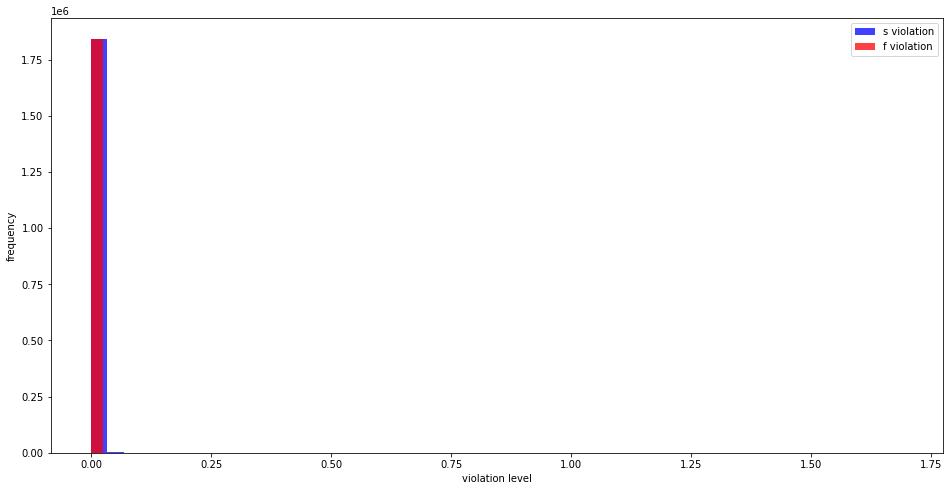

In [ ]:
# violation level
s_violation = np.abs(s_pred)-f_max_numpy #/ f_max_numpy
s_violation_level = np.maximum(s_violation,0)
s_violation_level = np.divide(s_violation_level,f_max_numpy)
s_vio_lvl = np.reshape(s_violation_level,n_line*n_sample)

print('S violation level:')
print('mean:',np.mean(s_vio_lvl))
print('median:',np.median(s_vio_lvl))
print('max:',np.max(s_vio_lvl))
print('std:',np.std(s_vio_lvl))
print('p99:',np.percentile(s_vio_lvl,99))

f_violation = np.abs(flow_est)-f_max_numpy #/ f_max_numpy
f_violation_level = np.maximum(f_violation,0)
f_violation_level = np.divide(f_violation_level,f_max_numpy)
f_vio_lvl = np.reshape(f_violation_level,n_line*n_sample)

print('f violation level:')
print('mean:',np.mean(f_vio_lvl))
print('median:',np.median(f_vio_lvl))
print('max:',np.max(f_vio_lvl))
print('std:',np.std(f_vio_lvl))
print('p99:',np.percentile(f_vio_lvl,99))

fig4 = plt.figure(figsize=(16, 8))
plt.hist(s_vio_lvl, bins = 50, facecolor='b', alpha=0.75,label = 's violation')
plt.hist(f_vio_lvl, bins = 50, facecolor='r', alpha=0.75,label = 'f violation')
plt.legend(loc="upper right")
plt.xlabel('violation level')
plt.ylabel('frequency')
# plt.title('injection histogram')
plt.show()

In [ ]:
np.max(s_violation_level)
# s_violation_level[:,0]
# print(s_pred[:,0])
# print(f_max_numpy)

1.6905286371955561

In [ ]:
# # solve for Q
# from scipy.optimize import fsolve

# # print(np.max(theta*180/2/math.pi),np.max(theta_true*180/2/math.pi))

# def PF_eq(Q,V,G_mat,B_mat,n_bus,line_loc):
#   PF_obj = [None]*n_bus
#   for i in range(n_bus):
#     PF_obj[i] = 

#   return PF_obj

# line_loc = np.nonzero(G_mat) # index of nonzero entries
# root = fsolve(PF_eq, np.zeros(118, args=(y_pred1[:,1,:0],G_mat,B_mat,n_bus,line_loc))